# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

## Overview

Building and scoring molecules can be further streamlined by employing our established protocol. Here we show how to quickly build a library and score the entire library. 

In [1]:
import pandas as pd
import prody
from rdkit import Chem

import fegrow
from fegrow import ChemSpace

from fegrow.testing import core_5R83_path, rec_5R83_path, data_5R83_path

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_3993021/1015952767.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# Prepare the ligand template

In [2]:
#!grep "XEY" 7l10.pdb > in.pdb
!obabel -ipdb new-core.pdb -O in-H.sdf -p 7

1 molecule converted


In [3]:
#scaffold = Chem.SDMolSupplier(core_5R83_path)[0]
scaffold = Chem.SDMolSupplier('in-H.sdf')[0]

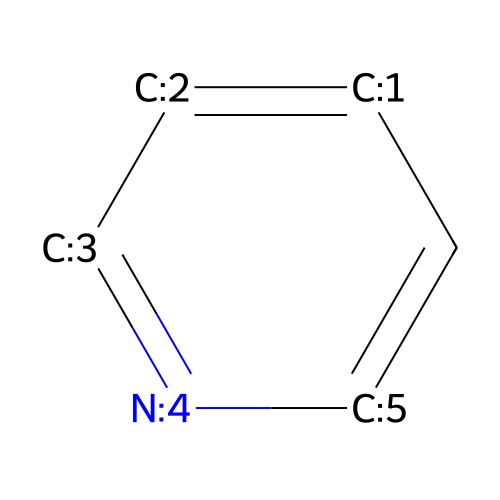

In [4]:
toview = fegrow.RMol(scaffold)
toview.rep2D(idx=True, size=(500, 500))

In [5]:
with open('smiles-test-SARS.txt') as f:
    mols = f.read().splitlines()

In [6]:
mols[0]

'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2ccncn2)c2cc(Cl)ccc2C1=O'

In [7]:
#mols = ['C1(OCCC)=CC=CN=C1',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2ccncn2)c2cc(Cl)ccc2C1=O',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2CNc2cnn(C)c2)c2cc(Cl)ccc2C1=O',
#        'Cc1cnc(CN2C[C@@]3(C(=O)N(c4cncc5ccccc45)C[C@@H]3C)c3cc(F)ccc3C2=O)cn1',
#        'CNC(=O)CN1C[C@@]2(C(=O)N(c3cncc4ccccc34)C[C@@H]2COC(C)C)c2cc(Cl)ccc2C1=O',
#        'C[C@H]1CN(c2cncc3ccccc23)C(=O)[C@@]12CN(Cc1nccn1C)C(=O)c1ccc(F)cc12'
#       ]

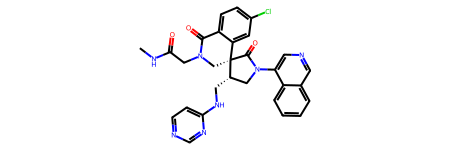

In [8]:
Chem.MolFromSmiles(mols[0])

In [9]:
pattern = scaffold

for i in range(len(mols)):
    mol = Chem.MolFromSmiles(mols[i])
    if mol.HasSubstructMatch(pattern) == False:
        print(i, mols[i])

33 C[C@H](NC(=O)COS(N)(=O)=O)c1cc(Cl)cc(-c2ccc(S(N)(=O)=O)cc2)c1
94 CNS(=O)(=O)OCC(=O)N[C@@H](C)c1cc(Cl)cc(-c2ccc(S(N)(=O)=O)cc2)c1


As we are using already prepared Smiles that have the scaffold as a substructure, it is not needed to set any growing vector. 

In [10]:
from dask.distributed import LocalCluster
lc = LocalCluster(processes=True, n_workers=None, threads_per_worker=1)

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38487 instead
  warnings.warn(
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '

In [11]:
# create the chemical space
cs = ChemSpace(dask_cluster=lc)
cs

Failed to patch pandas - unable to change molecule rendering


Dask can be watched on http://127.0.0.1:38487/status


,Smiles,score,h,Training,Success,enamine_searched,enamine_id,2D


In [12]:
#cs._dask_cluster

In [13]:
# we're not growing the scaffold, we're superimposing bigger molecules on it
cs.add_scaffold(scaffold)

/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/fegrow/package.py:799: UserWarning: The template does not have an attachement (Atoms with index 0, or in case of Smiles the * character. )
  warnings.warn("The template does not have an attachement (Atoms with index 0, "


In [14]:
# get the protein-ligand complex structure
#!wget -nc https://files.rcsb.org/download/3vf6.pdb

# load the complex with the ligand
sys = prody.parsePDB('complex.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
#rec_final = prody.parsePDB("rec_final.pdb")
#rec_final = prody.parsePDB("out.pdb")

# fix the receptor file (missing residues, protonation, etc)
##fegrow.fix_receptor("7t79-H-prep.pdb", "rec_final.pdb")

# load back into prody
##rec_final = prody.parsePDB("rec_final.pdb")

#!grep "ATOM" ../structures/7t79-H.pdb > rec_final.pdb
#cs.add_protein(rec_5R83_path)
cs.add_protein('rec_final.pdb')

@> 9278 atoms and 1 coordinate set(s) were parsed in 0.10s.


In [15]:
# load 50k Smiles
#smiles = pd.read_csv('csv/arthor-hits-2024Mar26-0918.csv',
#                     names=["Smiles", "??", "db"],
#                     index_col=0).Smiles

#smiles = pd.read_csv('smiles.csv').Smiles.to_list()


# take all 20000
#smiles = smiles.apply(lambda r: r.split()[0])
smiles = mols[0:]

# here we add Smiles which should already have been matched
# to the scaffold (rdkit Mol.HasSubstructureMatch)
#cs.add_smiles(smiles.to_list(), protonate=True)
cs.add_smiles(smiles, protonate=True)
cs

Failed to patch pandas - unable to change molecule rendering


,Smiles,score,h,Training,Success,enamine_searched,enamine_id,2D
0,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8ac0>
1,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8a50>
2,C(c1c(nc(C(N2C([C@@]3(C(=O)N(c4c(nc(c5c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8ba0>
3,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8b30>
4,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8c80>
...,...,...,...,...,...,...,...,...
93,C(C(n1nc(c(c1C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007bb290>
94,C(N(S(=O)(=O)OC(C(=O)N([C@@](C([H])([H])[H])(c...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007bb300>
95,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007bb370>
96,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<NA>,<NA>,False,NaN,False,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fc1007bb3e0>


In [16]:
cs.evaluate(num_conf=500, gnina_gpu=True, penalty=0.0, al_ignore_penalty=False)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

Generated 8 conformers. 
Removed 1 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/7 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  57%|█████████████▏         | 4/7 [00:15<00:10,  3.35s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings

Generated 15 conformers. 
Removed 6 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                               | 0/9 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  67%|███████████████▎       | 6/9 [00:25<00:13,  4.38s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings

Generated 207 conformers. 
Removed 129 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/78 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:   4%|▊                     | 3/78 [00:10<03:47,  3.03s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   8%|█▋                    | 6/78 [00:19<03:35,  2.99s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: User

Generated 207 conformers. 
Removed 118 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  12%|██▌                   | 9/78 [00:28<03:35,  3.12s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  14%|██▉                  | 11/78 [00:33<03:08,  2.81s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarr

Generated 32 conformers. 
Removed 18 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  27%|█████▋               | 24/89 [01:20<03:11,  2.95s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  42%|████████▉            | 33/78 [01:55<02:45,  3.68s/it]

Generated 344 conformers. 
Removed 205 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                             | 0/139 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  46%|█████████▋           | 36/78 [02:08<02:55,  4.19s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   2%|▍                    | 3/139 [00:13<09:15,  4.09s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: User

Generated 29 conformers. 
Removed 28 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   4%|▉                    | 6/139 [00:27<09:29,  4.28s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:   5%|█                    | 7/139 [00:30<08:47,  4.00s/it]

Generated 116 conformers. 
Removed 85 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  29%|██████▎               | 4/14 [00:44<01:30,  9.05s/it]2025-03-03 18:06:07,355 - distributed.worker - WARNING - Compute Failed
Key:       _evaluate_atomic-0ca52a23-8a22-4bea-89c6-4a1ff31daeb9
Function:  execute_task
args:      ((<function apply at 0x7fde7bdd27a0>, <function _evaluate_atomic at 0x7fdd7cf0de10>, [<rdkit.Chem.rdchem.Mol object at 0x7fdd7cefb6a0>, 'C(N(S(=O)(=O)OC(C(=O)N([C@@](C([H])([H])[H])(c1c(c(Cl)c(c(c2c(c(c(S(=O)(=O)N([H])[H])c(c2[H])[H])[H])[H])c1[H])[H])[H])[H])[H])([H])[H])[H])([H])([H])[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 500], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', True]])))
kwargs:    {}
Exception: 'WrongCoreForMolecule("Molecule doesn\'t match the core. This can be caused by the order of SMILES, for example. You can install the python package \'ties\' to use MCS instead. ", ())'

Optimising conformer:  12%|██▎                 | 16/139 [01:08<08:22,  4.09s/it]/tank/home/ndc104

Generated 64 conformers. 
Removed 52 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  50%|██████████▌          | 39/78 [03:21<08:40, 13.34s/it]

Generated 189 conformers. 
Removed 162 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/27 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  19%|███▋                | 26/139 [01:59<08:07,  4.31s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  21%|████▏               | 29/139 [02:10<07:09,  3.91s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: Uni

Generated 62 conformers. 
Removed 46 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  55%|███████████▌         | 49/89 [03:58<03:10,  4.76s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  57%|████████████         | 51/89 [04:05<02:34,  4.06s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  77%|████████████████▏    | 60/78 [04:41<01:09,  3.85s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: User

Generated 101 conformers. 
Removed 86 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/15 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising

Generated 77 conformers. 
Removed 63 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


[W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  90%|██████████████████▊  | 70/78 [05:23<00:34,  4.26s/it]2025-03-03 18:09:00,430 - distributed.worker - WARNING - Compute Failed
Key:       _evaluate_atomic-650543f6-c78e-4d31-ac38-3ce7c342340f
Function:  execute_task
args:      ((<function apply at 0x7f00c584e7a0>, <function _evaluate_atomic at 0x7effc6c4fbe0>, [<rdkit.Chem.rdchem.Mol object at 0x7effc6c57650>, 'C([C@](N(C(=O)C(OS(=O)(=O)N([H])[H])([H])[H])[H])(c1c(c(Cl)c(c(c2c(c(c(S(=O)(=O)N([H])[H])c(c2[H])[H])[H])[H])c1[H])[H])[H])[H])([H])([H])[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf'

Generated 65 conformers. 
Removed 50 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  35%|███████             | 49/139 [03:49<06:50,  4.56s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  71%|██████████████▊      | 63/89 [05:20<01:59,  4.61s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:   0%|                               | 0/9 [00:00<?, ?it/s]

Generated 341 conformers. 
Removed 332 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


[W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  99%|████████████████████▋| 77/78 [05:58<00:04,  4.56s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  73%|███████████████▎     | 65/89 [05:32<02:09,  5.41s/it]

Generated 71 conformers. 
Removed 59 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  36%|███████▊              | 5/14 [01:12<02:23, 15.89s/it]

Generated 112 conformers. 
Removed 87 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  25%|█████▌                | 3/12 [01:00<03:35, 23.93s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:   0%|                              | 0/12 [00:00<?, ?it/s]

Generated 90 conformers. 
Removed 78 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  53%|███████████▋          | 8/15 [01:31<01:17, 11.02s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  47%|█████████▎          | 65/139 [05:42<12:13,  9.91s/it]

Generated 69 conformers. 
Removed 55 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  70%|██████████████▊      | 19/27 [04:45<03:14, 24.28s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  50%|███████████           | 6/12 [01:01<01:03, 10.64s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  55%|██████████▉         | 76/139 [06:29<04:37,  4.41s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimis

Generated 270 conformers. 
Removed 241 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/29 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  75%|████████████████▌     | 9/12 [02:32<00:51, 17.07s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


Generated 182 conformers. 
Removed 154 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/28 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  80%|████████████████▊    | 12/15 [03:42<00:44, 14.67s/it]

Generated 15 conformers. 
Removed 11 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  83%|█████████████████▌   | 10/12 [02:38<00:27, 13.72s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:   3%|▊                     | 1/29 [00:13<06:30, 13.95s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


Generated 66 conformers. 
Removed 57 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  92%|███████████████████▎ | 11/12 [02:46<00:12, 12.01s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  29%|██████▎               | 4/14 [01:11<02:24, 14.48s/it]

Generated 289 conformers. 
Removed 263 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/26 [00:00<?, ?it/s][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  87%|██████████████████▏  | 13/15 [04:00<00:31, 15.70s/it]

Generated 289 conformers. 
Removed 263 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  67%|██████████████▋       | 8/12 [01:41<01:08, 17.16s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  11%|██▌                    | 1/9 [00:11<01:33, 11.70s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  44%|██████████▏            | 4/9 [00:38<00:48,  9.72s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: Uni

Generated 130 conformers. 
Removed 111 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
[W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  21%|████▌                 | 6/29 [01:46<06:37, 17.30s/it]

Generated 295 conformers. 
Removed 263 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  35%|███████▌              | 9/26 [01:21<02:24,  8.51s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  42%|████████▉            | 11/26 [01:44<02:43, 10.87s/it]

Generated 62 conformers. 
Removed 56 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  17%|███▊                   | 1/6 [00:06<00:32,  6.46s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  37%|████████              | 7/19 [00:42<01:00,  5.06s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  42%|█████████▎            | 8/19 [00:48<00:59,  5.45s/it]

Generated 378 conformers. 
Removed 339 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|███████████▌           | 3/6 [00:19<00:18,  6.16s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  69%|██████████████▌      | 18/26 [02:50<01:01,  7.70s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  61%|████████████▋        | 17/28 [03:16<01:45,  9.63s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: Uni

Generated 16 conformers. 
Removed 8 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  64%|█████████████▌       | 18/28 [03:26<01:34,  9.49s/it]

Generated 17 conformers. 
Removed 10 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  73%|█████████████▊     | 101/139 [10:13<02:22,  3.74s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  34%|███████▏             | 11/32 [01:53<03:29,  9.98s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  38%|████████▋              | 3/8 [00:21<00:34,  6.93s/it]

Generated 438 conformers. 
Removed 431 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  75%|██████████████▏    | 104/139 [10:24<02:13,  3.81s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())


Generated 310 conformers. 
Removed 289 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  76%|██████████████▎    | 105/139 [10:27<02:06,  3.71s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  81%|████████████████▉    | 21/26 [03:30<00:53, 10.69s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")
Optimising conformer:  86%|███████████████████▋   | 6/7 [00:33<00:05,  5.60s/it]

Generated 299 conformers. 
Removed 278 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  75%|█████████████████▎     | 6/8 [00:41<00:13,  6.52s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:  92%|███████████████████▍ | 24/26 [03:49<00:17,  8.58s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  62%|█████████████        | 18/29 [04:18<05:00, 27.28s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/__init__.py:55: User

Generated 300 conformers. 
Removed 276 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  29%|██████▌                | 2/7 [00:43<01:35, 19.17s/it][W BinaryOps.cpp:601] Warning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (function operator())
Optimising conformer:   0%|                              | 0/77 [00:00<?, ?it/s]

Generated 185 conformers. 
Removed 108 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  69%|██████████████▍      | 20/29 [04:41<02:50, 18.96s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  79%|████████████████▌    | 22/28 [04:57<02:21, 23.62s/it]

Generated 76 conformers. 
Removed 50 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  87%|████████████████▌  | 121/139 [11:41<01:21,  4.54s/it]2025-03-03 18:17:12,539 - distributed.worker - WARNING - Compute Failed
Key:       _evaluate_atomic-9b8b2a14-3bfd-416e-82d5-311f7cf39789
Function:  execute_task
args:      ((<function apply at 0x7fec5c38a7a0>, <function _evaluate_atomic at 0x7feb5d4bbeb0>, [<rdkit.Chem.rdchem.Mol object at 0x7feb5d4c2340>, 'C(n1nc(c2c(nc(c(N(C(=O)[C@@]3(C(N(S(=O)(=O)c4c(c(c(Cl)c(c34)[H])[H])[H])[H])([H])[H])[H])[H])c12)[H])[H])[H])([H])([H])[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 500], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', True]])))
kwargs:    {}
Exception: "Exception('No Conformers')"

Optimising conformer:  90%|█████████████████  | 125/139 [11:58<00:58,  4.19s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(

Generated 198 conformers. 
Removed 175 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/17 [00:00<?, ?it/s]

Generated 66 conformers. 
Removed 49 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  94%|█████████████████▉ | 131/139 [12:19<00:29,  3.66s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   0%|                               | 0/6 [00:00<?, ?it/s]

Generated 11 conformers. 
Removed 5 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  22%|████▊                 | 5/23 [00:42<02:36,  8.71s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  32%|██████▊              | 25/77 [01:47<03:25,  3.96s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  96%|████████████████████▏| 25/26 [01:47<00:04,  4.11s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
O

Generated 84 conformers. 
Removed 68 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   6%|█▍                    | 1/16 [00:06<01:40,  6.69s/it]

Generated 141 conformers. 
Removed 90 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  67%|██████████████       | 26/39 [06:06<02:15, 10.43s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   6%|█▎                    | 3/51 [00:12<03:08,  3.93s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  96%|████████████████████▏| 23/24 [04:24<00:09,  9.18s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
O

Generated 145 conformers. 
Removed 128 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  38%|████████▎             | 6/16 [00:57<01:44, 10.47s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  37%|███████▊             | 19/51 [01:14<02:11,  4.11s/it]

Generated 90 conformers. 
Removed 64 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/23 [00:00<?, ?it/s]

Generated 133 conformers. 
Removed 110 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  55%|███████████▌         | 28/51 [01:54<01:50,  4.79s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  59%|████████████▎        | 30/51 [02:01<01:28,  4.21s/it]

Generated 136 conformers. 
Removed 108 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  65%|█████████████▌       | 33/51 [02:12<01:06,  3.71s/it]

Generated 71 conformers. 
Removed 61 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|██████████▌          | 13/26 [00:57<00:51,  3.97s/it]

Generated 98 conformers. 
Removed 66 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  53%|███████████▏         | 17/32 [01:07<00:53,  3.59s/it]

Generated 32 conformers. 
Removed 18 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  29%|██████▎               | 8/28 [01:30<03:34, 10.72s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  36%|███████▌             | 10/28 [01:40<02:19,  7.73s/it]

Generated 69 conformers. 
Removed 51 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  72%|███████████████      | 23/32 [01:29<00:34,  3.79s/it]

Generated 212 conformers. 
Removed 169 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  57%|████████████▌         | 8/14 [01:15<00:44,  7.49s/it]

Generated 194 conformers. 
Removed 161 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  78%|████████████████▍    | 18/23 [02:53<00:49,  9.92s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   3%|▋                     | 1/33 [00:06<03:36,  6.78s/it]2025-03-03 18:25:27,669 - distributed.worker - WARNING - Compute Failed
Key:       _evaluate_atomic-35cae2a3-d491-4e9c-ac3a-96c69d13b115
Function:  execute_task
args:      ((<function apply at 0x7f595aee27a0>, <function _evaluate_atomic at 0x7f585bf38f70>, [<rdkit.Chem.rdchem.Mol object at 0x7f585bf48ef0>, 'O=C1N([C@@]2(C(C(Oc3c(c(nc(c23)[H])[H])[H])([H])[H])([H])[H])C(=O)N1c1c(nc(c2c(c(c(c(c12)[H])[H])[H])[H])[H])[H])[H]', 'rec_final.pdb'], (<class 'dict'>, [['h', None], ['num_conf', 500], ['minimum_conf_rms', 0.5], ['scoring_function', None], ['gnina_gpu', True]])))
kwargs:    {

Generated 365 conformers. 
Removed 313 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  39%|████████▌             | 7/18 [01:28<03:01, 16.52s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   8%|█▋                    | 4/52 [00:32<06:20,  7.93s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  61%|████████████▋        | 17/28 [03:46<02:54, 15.91s/it]

Generated 133 conformers. 
Removed 110 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/23 [00:00<?, ?it/s]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  15%|███▍                  | 8/52 [01:06<05:29,  7.49s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  71%|███████████████      | 20/28 [04:13<01:31, 11.48s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
O

Generated 271 conformers. 
Removed 143 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   5%|█▏                   | 7/128 [00:31<08:20,  4.14s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   9%|█▉                  | 12/128 [00:50<07:29,  3.87s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  96%|████████████████████▎| 27/28 [05:25<00:13, 13.12s/it]/

Generated 62 conformers. 
Removed 46 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  91%|███████████████████▏ | 21/23 [03:23<00:19,  9.83s/it]

Generated 66 conformers. 
Removed 49 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  31%|██████▎             | 40/128 [02:51<06:02,  4.12s/it]

Generated 114 conformers. 
Removed 68 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  34%|██████▉             | 44/128 [03:11<06:01,  4.30s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  11%|██▍                   | 5/46 [00:27<03:30,  5.14s/it]

Generated 196 conformers. 
Removed 126 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  37%|███████▎            | 47/128 [03:22<05:32,  4.10s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   0%|                              | 0/16 [00:00<?, ?it/s]

Generated 66 conformers. 
Removed 50 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  56%|████████████▍         | 9/16 [02:03<01:20, 11.50s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  62%|█████████████▏       | 10/16 [02:09<00:59,  9.88s/it]

Generated 13 conformers. 
Removed 7 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  49%|█████████▊          | 63/128 [04:34<04:38,  4.28s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   0%|                              | 0/19 [00:00<?, ?it/s]

Generated 96 conformers. 
Removed 77 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  39%|████████▏            | 18/46 [02:08<03:19,  7.12s/it]

Generated 283 conformers. 
Removed 240 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  43%|█████████▏           | 20/46 [02:18<02:36,  6.03s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  29%|██████               | 15/52 [06:57<11:02, 17.90s/it]

Generated 28 conformers. 
Removed 28 conformers. 
Generated 321 conformers. 
Removed 280 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  14%|███                  | 10/70 [02:34<14:27, 14.46s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  14%|███                   | 6/43 [01:01<05:59,  9.72s/it]

Generated 66 conformers. 
Removed 54 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  70%|██████████████▌      | 32/46 [03:29<01:31,  6.55s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  72%|███████████████      | 33/46 [03:33<01:16,  5.86s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  63%|████████████▋       | 81/128 [06:42<03:21,  4.29s/it]

Generated 306 conformers. 
Removed 288 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 17/17 [04:16<00:00, 15.11s/it]


Generated 113 conformers. 
Removed 83 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  33%|██████▉              | 23/70 [04:53<10:49, 13.82s/it]

Generated 300 conformers. 
Removed 281 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  70%|██████████████      | 90/128 [08:22<03:03,  4.84s/it]

Generated 290 conformers. 
Removed 273 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  47%|█████████▊           | 20/43 [03:50<03:48,  9.95s/it]

Generated 10 conformers. 
Removed 10 conformers. 
Generated 69 conformers. 
Removed 62 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  50%|██████████▌          | 26/52 [10:37<06:30, 15.01s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


Generated 49 conformers. 
Removed 40 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  42%|█████████▎            | 8/19 [01:24<01:51, 10.17s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  58%|████████████▏        | 11/19 [01:49<01:10,  8.78s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  78%|█████████████████▉     | 7/9 [01:38<00:24, 12.16s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
O

Generated 91 conformers. 
Removed 65 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/26 [00:00<?, ?it/s]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  73%|███████████████▎     | 51/70 [08:22<02:12,  6.96s/it]

Generated 484 conformers. 
Removed 476 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  93%|███████████████████▌ | 40/43 [06:41<00:28,  9.52s/it]

Generated 283 conformers. 
Removed 240 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  79%|████████████████▌    | 55/70 [08:41<01:20,  5.37s/it]

Generated 493 conformers. 
Removed 473 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  98%|██████████████████▌| 125/128 [12:06<00:33, 11.27s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:   0%|                              | 0/10 [00:00<?, ?it/s]

Generated 79 conformers. 
Removed 69 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  87%|██████████████████▏  | 45/52 [14:57<01:11, 10.16s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|█████████████████████| 10/10 [01:03<00:00,  6.32s/it]
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  63%|█████████████▏       | 27/43 [16:50<02:14,  8.39s/it]

Generated 104 conformers. 
Removed 67 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/10 [00:00<?, ?it/s]

Generated 263 conformers. 
Removed 253 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   8%|█▊                    | 3/37 [00:13<02:23,  4.21s/it]

Generated 95 conformers. 
Removed 80 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  19%|████▏                 | 7/37 [00:24<01:32,  3.09s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  60%|█████████████▏        | 6/10 [00:47<00:24,  6.14s/it]

Generated 220 conformers. 
Removed 186 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  95%|███████████████████▉ | 19/20 [03:13<00:09,  9.91s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  58%|████████████▏        | 25/43 [03:48<02:03,  6.84s/it]

Generated 282 conformers. 
Removed 247 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  77%|████████████████     | 33/43 [04:19<00:37,  3.71s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


Generated 36 conformers. 
Removed 26 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  44%|█████████▎           | 15/34 [00:57<01:05,  3.47s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  70%|███████████████▍      | 7/10 [00:16<00:06,  2.27s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer: 100%|█████████████████████| 34/34 [01:54<00:00,  3.38s/it]


Generated 281 conformers. 
Removed 254 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   4%|▊                     | 1/27 [00:05<02:33,  5.91s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)


Generated 145 conformers. 
Removed 128 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   7%|█▋                    | 2/27 [00:12<02:41,  6.46s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  34%|███████▏             | 12/35 [02:11<04:14, 11.06s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
Optimising conformer:  24%|█████▏                | 4/17 [00:15<00:49,  3.79s/it]/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/parmed/structure.py:1799: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  coords = np.array(value, dtype=np.float64, copy=False, subok=True)
O

Generated 472 conformers. 
Removed 459 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  97%|████████████████████▍| 34/35 [03:40<00:03,  3.94s/it]

Generated 195 conformers. 
Removed 171 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  78%|████████████████▎    | 21/27 [01:55<00:26,  4.38s/it]

Generated 195 conformers. 
Removed 171 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 35/35 [03:43<00:00,  6.40s/it]


Generated 147 conformers. 
Removed 128 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  85%|█████████████████▉   | 23/27 [02:18<00:29,  7.36s/it]

Generated 132 conformers. 
Removed 103 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  71%|██████████████▉      | 17/24 [01:13<00:29,  4.27s/it]

Generated 289 conformers. 
Removed 263 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/43 [00:00<?, ?it/s]

Generated 283 conformers. 
Removed 240 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  19%|████▏                 | 5/26 [00:16<01:10,  3.34s/it]

Generated 225 conformers. 
Removed 199 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:  97%|████████████████████▎| 28/29 [01:50<00:03,  3.03s/it]

Generated 299 conformers. 
Removed 278 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer:   0%|                              | 0/23 [00:00<?, ?it/s]

Generated 168 conformers. 
Removed 145 conformers. 
using ani2x
/tank/home/ndc104/anaconda3/envs/fegrowcs/lib/python3.10/site-packages/torchani/resources/
failed to equip `nnpops` with error: No module named 'NNPOps'


Optimising conformer: 100%|█████████████████████| 23/23 [01:31<00:00,  3.99s/it]


,Smiles,Mol,score,h,Training,Success,enamine_searched,enamine_id
0,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1205c2930>,6.622,<NA>,True,True,False,NaN
1,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc0e05b9bc0>,7.026,<NA>,True,True,False,NaN
2,C(c1c(nc(C(N2C([C@@]3(C(=O)N(c4c(nc(c5c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1202fe390>,6.489,<NA>,True,True,False,NaN
3,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc120322b60>,6.629,<NA>,True,True,False,NaN
4,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7fc0e06ac590>,6.825,<NA>,True,True,False,NaN
...,...,...,...,...,...,...,...,...
93,C(C(n1nc(c(c1C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(...,<fegrow.package.RMol object at 0x7fc1004ce200>,6.845,<NA>,True,True,False,NaN
94,C(N(S(=O)(=O)OC(C(=O)N([C@@](C([H])([H])[H])(c...,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8820>,0.0,<NA>,True,False,False,NaN
95,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1004ce2f0>,6.622,<NA>,True,True,False,NaN
96,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc154476e80>,6.629,<NA>,True,True,False,NaN


In [17]:
cs.df

,Smiles,Mol,score,h,Training,Success,enamine_searched,enamine_id
0,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1205c2930>,6.622,<NA>,True,True,False,NaN
1,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc0e05b9bc0>,7.026,<NA>,True,True,False,NaN
2,C(c1c(nc(C(N2C([C@@]3(C(=O)N(c4c(nc(c5c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1202fe390>,6.489,<NA>,True,True,False,NaN
3,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc120322b60>,6.629,<NA>,True,True,False,NaN
4,C([C@]1(C(N(c2c(nc(c3c(c(c(c(c23)[H])[H])[H])[...,<fegrow.package.RMol object at 0x7fc0e06ac590>,6.825,<NA>,True,True,False,NaN
...,...,...,...,...,...,...,...,...
93,C(C(n1nc(c(c1C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(...,<fegrow.package.RMol object at 0x7fc1004ce200>,6.845,<NA>,True,True,False,NaN
94,C(N(S(=O)(=O)OC(C(=O)N([C@@](C([H])([H])[H])(c...,<rdkit.Chem.rdchem.Mol object at 0x7fc1007b8820>,0.0,<NA>,True,False,False,NaN
95,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc1004ce2f0>,6.622,<NA>,True,True,False,NaN
96,C(N(C(=O)C(N1C([C@@]2(C(=O)N(c3c(nc(c4c(c(c(c(...,<fegrow.package.RMol object at 0x7fc154476e80>,6.629,<NA>,True,True,False,NaN


In [18]:
cs.to_sdf("cs_optimised_molecules.sdf")

In [19]:
for i in range (len(cs)):
    try:
        cs[i].to_file("best_conformers_{0}.pdb".format(i))
    except AttributeError:
        print("No conformer for molecule", i)

No conformer for molecule 22
No conformer for molecule 33
No conformer for molecule 42
No conformer for molecule 94


In [20]:
cs.df.to_csv('SARS-out.csv', index=True)